# Sea Ice Advance and Retreat

Using the daily calculated sea ice extent, figure out the day in each year when sea ice is at maximum and minimum extent

In [1]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import sys
sys.path.append('/g/data/jk72/as2285/miz/')

from utils.sea_ice_conc import sea_ice_conc

In [3]:
%matplotlib inline

In [4]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2022
#TO-DO - move file paths here?

# Open the dataset

For this, we are going to treat historical and near real-time data as equivalent.

In [5]:
#lists of both the historical and near real-time files
daily_files = ! ls -d /g/data/jk72/MIZ/NSIDC/G02202_V4/seaice_conc_daily*.nc /g/data/jk72/MIZ/NSIDC/G10016_V2/daily/*.nc

In [6]:
#open it all
cdr_daily_ds=xr.open_mfdataset(
    daily_files, combine='nested',concat_dim='tdim', data_vars='minimal'
).swap_dims(
    {
        'tdim':'time', 
        'x':'xgrid',
        'y':'ygrid'
    }
).rename( #tidy-up
    {'xgrid':'x','ygrid':'y'}
)  

In [7]:
cdr_daily_ds

<xarray.Dataset>
Dimensions:                      (time: 15916, y: 332, x: 316)
Coordinates:
  * time                         (time) datetime64[ns] 1978-10-25 ... 2022-05-22
  * x                            (x) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
  * y                            (y) float32 4.338e+06 4.312e+06 ... -3.938e+06
Data variables:
    cdr_seaice_conc              (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    projection                   |S1 b''
    qa_of_cdr_seaice_conc        (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (time, y, x) float32 dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    latitude                     (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
    longitude                    (y, x) float32 dask.array<chunksize=(332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [8]:
daily_conc_da=cdr_daily_ds.cdr_seaice_conc

daily_conc_da=daily_conc_da.where(daily_conc_da<=1) #set flagged values to Nan

In [9]:
daily_conc_da

<xarray.DataArray 'cdr_seaice_conc' (time: 15916, y: 332, x: 316)>
dask.array<where, shape=(15916, 332, 316), dtype=float32, chunksize=(366, 332, 316), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2022-05-22
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc qa_of_cdr_seaice_conc
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

# Define groups starting ending in mid-feb each year

We want to look at each "sea-ice year", which will start/end mid feb (day 46/411 in the year).

In [10]:
# year of the first entry in the dataset
first_year=cdr_daily_ds.time[0].dt.year.values

# if that year doesn't include the sea-ice minimum, increment to the next year
if cdr_daily_ds.time[0].dt.dayofyear>=46:
    first_year+=1

first_year

array(1979)

In [11]:
# year of last entry in the dataset
current_year=cdr_daily_ds.time[-1].dt.year.values

# if that year doesn't include the sea-ice minimum, increment to the previous year
if cdr_daily_ds.time[0].dt.dayofyear<=46:
    current_year-=1

current_year

array(2022)

We are going to use groupby bins, so we need to define bins starting and ending 46th day of each year

In [12]:
years=np.arange(first_year,current_year+2,1)
year_bins=np.array([np.datetime64(str(iYear)+'-02-15') for iYear in years])
year_labels=[iYear for iYear in years[0:-1]]

# Functions to find advance day and retreat day

We need a function to find:
- first time the concentration exceeds 15% for at least 5 days
- last time concentration drops below 15%

the input would be an xarray starting and ending at the sea-ice minimum (15-feb)

To-Do: what happpens if there is sea ice on 15-feb but not on 15-march??

In [13]:
def day_of_advance(conc_da):
    # find times when the concentration for 5 days is >=0.15
    has_ice_da=((conc_da>=0.15).rolling(time=5).mean('time')==1)
    
    # day of advance is the first day when has_ice is true
    advance_day_da=has_ice_da.idxmax(dim='time').where( #idxmax returns first time when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    )
    
    advance_index_da=has_ice_da.argmax(dim='time').where( #argmax returns first index when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    ).rename('index')
    
    return xr.merge([advance_day_da,advance_index_da])

In [14]:
def day_of_retreat(conc_da):
    # find times when the concentration for 5 days is >=0.15, i.e. year has some sea-ice
    has_ice_da=((conc_da>=0.15).rolling(time=5).mean('time')==1)
    
    # criteria for end of sea ice
    no_ice_da=(conc_da>=0.15)
    
    retreat_day_da=no_ice_da.sel(
        time=(no_ice_da.time[::-1]) #index from the end to the start
    ).idxmax(dim='time').where( #idxmax returns first time when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    )
    
    length_of_year=365 #days
    if no_ice_da.time[0].dt.is_leap_year:
        length_of_year=366
    
    retreat_index_da=length_of_year-no_ice_da.sel(
        time=(no_ice_da.time[::-1]) #index from the end to the start
    ).argmax(dim='time').where( #argmax returns first index when true is found
        (has_ice_da.any('time')!=0) #filter out pixels with no-ice
    ).rename('index')
    
    return xr.merge([retreat_day_da, retreat_index_da])
    

# Calculate advance day / retreat day and season

For year of the groups defined (stating/ending Feb 15), find the day when advance and retreat starts:

In [15]:
adv_day_ds=daily_conc_da.groupby_bins('time',year_bins, labels=year_labels).apply(day_of_advance).rename({'time_bins':'year'})

In [16]:
adv_day_ds

<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    index    (year, y, x) float64 dask.array<chunksize=(1, 332, 316), meta=np.ndarray>

In [17]:
ret_day_ds=daily_conc_da.groupby_bins('time',year_bins, labels=year_labels).apply(day_of_retreat).rename({'time_bins':'year'})

In [18]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,memory="47GB")
client = Client(cluster)

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44851 instead
  warnings.warn(


In [19]:
cluster.scale(cores=16)

In [20]:
print(client)

<Client: 'tcp://10.0.128.142:41141' processes=0 threads=0, memory=0 B>


In [21]:
adv_day_ds.to_netcdf('/g/data/jk72/as2285/miz/data/adv_day.nc')

In [22]:
ret_day_ds.to_netcdf('/g/data/jk72/as2285/miz/data/ret_day.nc')

In [23]:
client.close()

In [24]:
print(client)

<Client: No scheduler connected>


# Example plots

In [25]:
adv_day_ds=xr.open_dataset('/g/data/jk72/as2285/miz/data/adv_day.nc')

In [26]:
adv_day_ds

<xarray.Dataset>
Dimensions:  (year: 44, x: 316, y: 332)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2018 2019 2020 2021 2022
  * x        (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y        (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
Data variables:
    time     (year, y, x) datetime64[ns] ...
    index    (year, y, x) float64 ...

In [27]:
ret_day_ds=xr.open_dataset('/g/data/jk72/as2285/miz/data/ret_day.nc')

Plots for sanity - compare concentrations to dates identified as advance date

No Ice example:

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.09.1/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


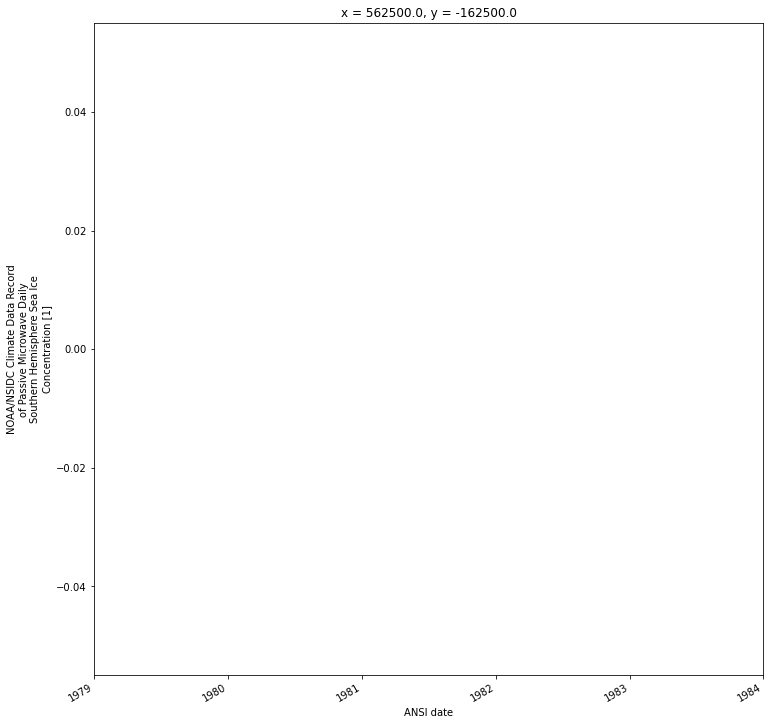

In [28]:
plt.figure(figsize=(12,12))
daily_conc_da.isel(x=180,y=180).plot(xlim=[np.datetime64('1979'),np.datetime64('1984')])

plt.vlines(adv_day_ds.time.isel(x=180,y=180).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=180).values,0,1, color='red')


Ice example

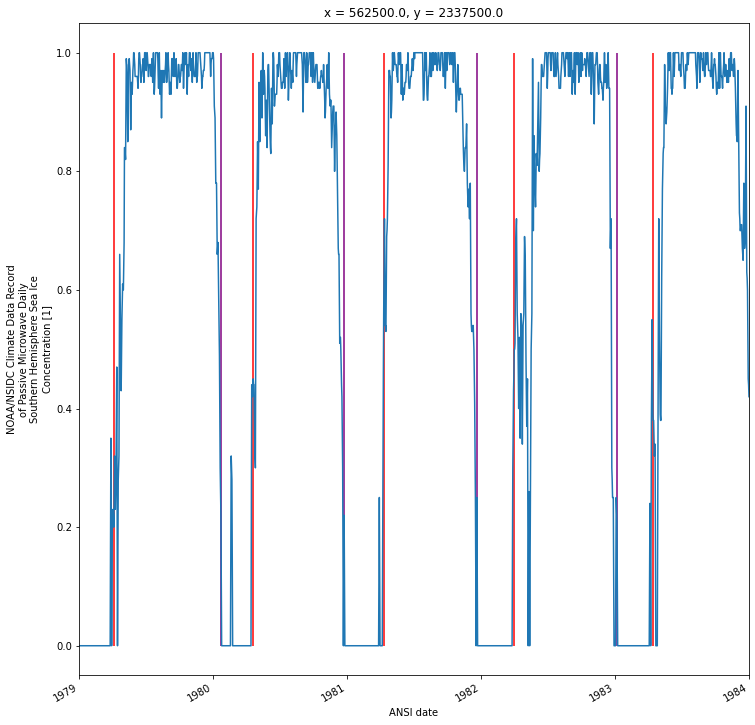

In [29]:
plt.figure(figsize=(12,12))
daily_conc_da.isel(x=180,y=80).plot(xlim=[np.datetime64('1979'),np.datetime64('1984')])

plt.vlines(adv_day_ds.time.isel(x=180,y=80).values,0,1, color='red')

plt.vlines(ret_day_ds.time.isel(x=180,y=80).values,0,1, color='purple')


# Plots of sea ice advance / retreat / duration for a year

In [30]:
YEAR=1982

Text(0.5, 1.0, 'Index + 46 days - Sea Ice Advance 1982')

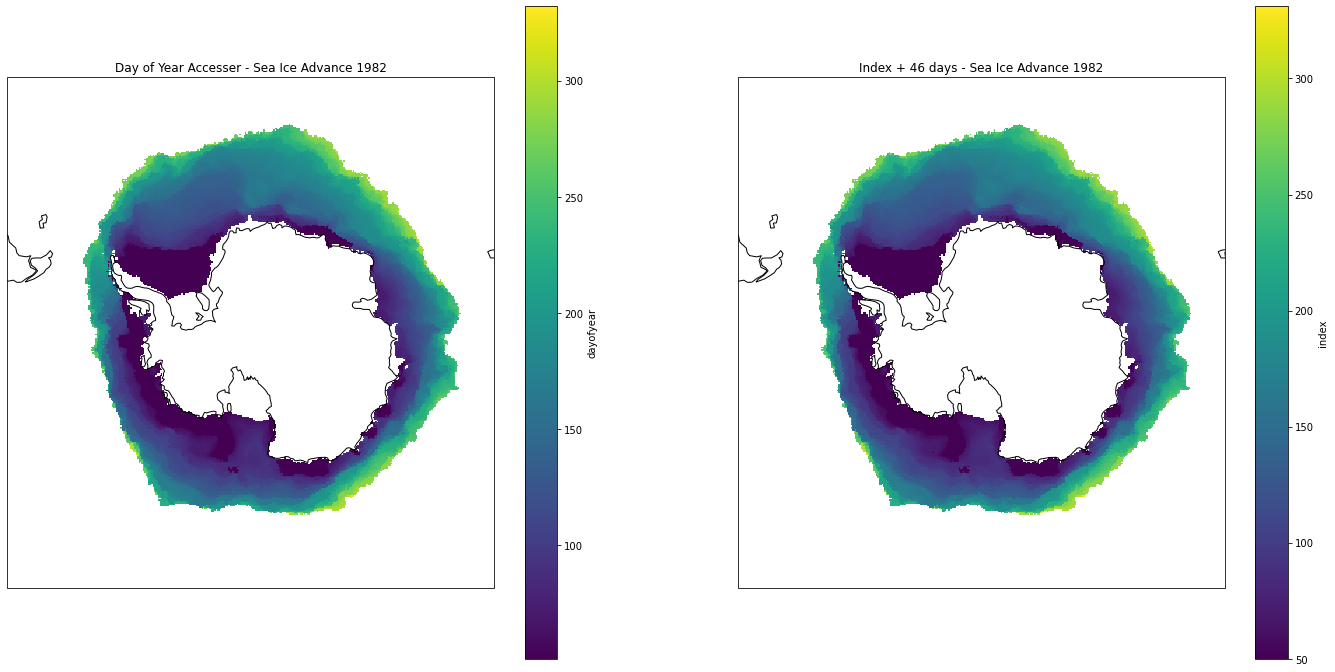

In [31]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

adv_day_ds.time.sel(year=YEAR).dt.dayofyear.plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accesser - Sea Ice Advance ' + str(YEAR) )

ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(adv_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 days - Sea Ice Advance ' + str(YEAR))

#check the two plots are the same :)

Text(0.5, 1.0, 'Index + 46 Days - Sea Ice Retreat 1982')

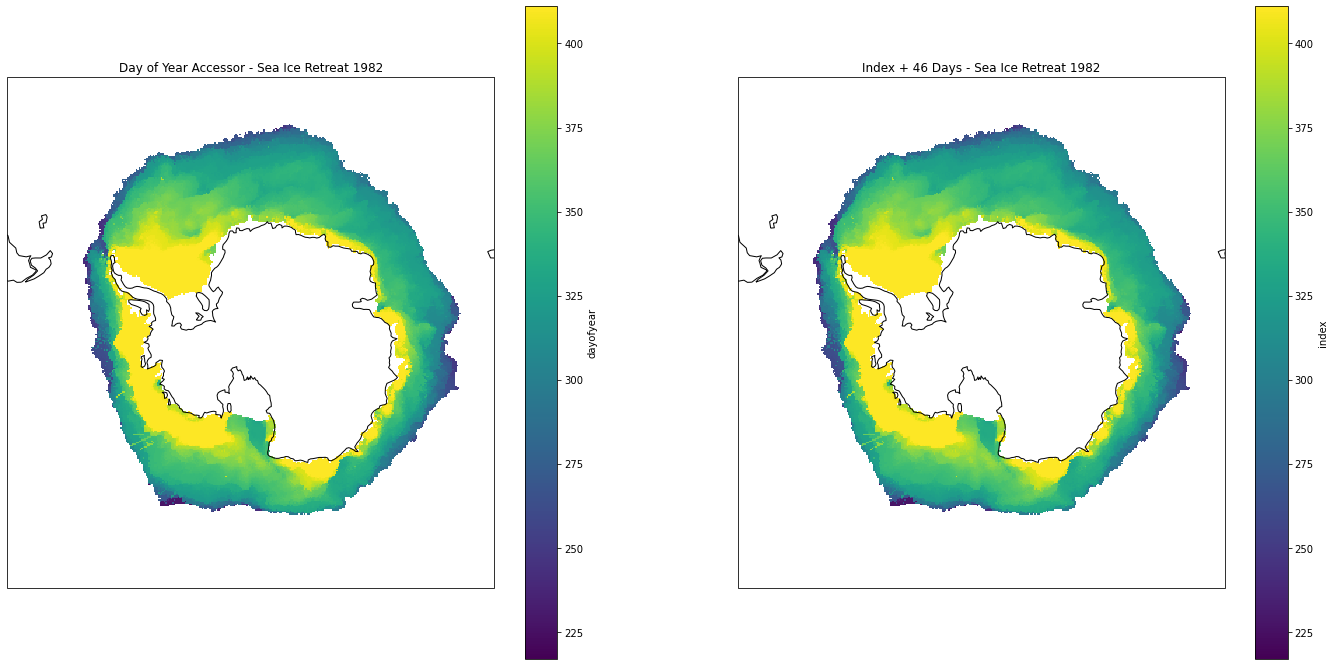

In [33]:
plt.figure(figsize=(24,12))
ax=plt.subplot(1,2,1,projection=ccrs.SouthPolarStereo())

ret_dayofyear_da=ret_day_ds.time.dt.dayofyear
ret_dayofyear_da=ret_dayofyear_da.where(ret_dayofyear_da>46,other=(ret_dayofyear_da+365))


ret_dayofyear_da.sel(year=YEAR).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Day of Year Accessor - Sea Ice Retreat ' + str(YEAR))


ax=plt.subplot(1,2,2,projection=ccrs.SouthPolarStereo())

(ret_day_ds.sel(year=YEAR).index+46).plot.pcolormesh(
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70)
)

ax.coastlines()
plt.title('Index + 46 Days - Sea Ice Retreat ' + str(YEAR))

Text(0.5, 1.0, 'Sea Ice Duration')

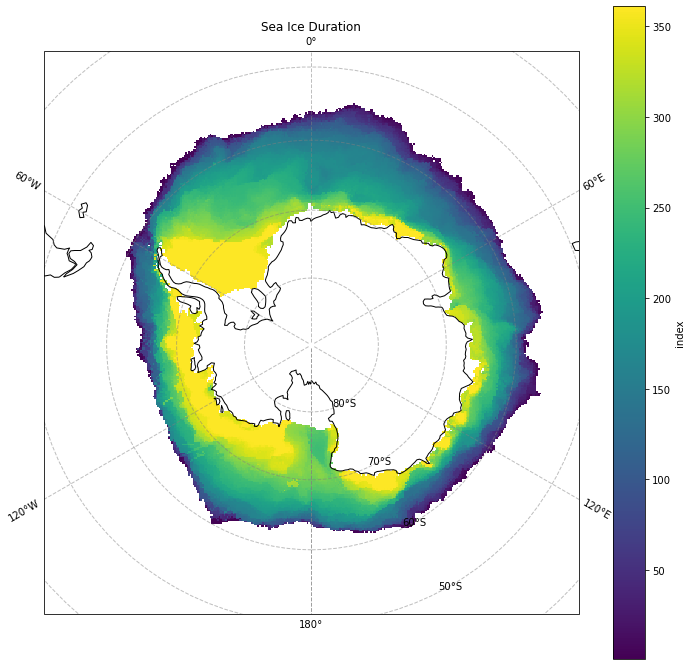

In [35]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))


duration_da=ret_day_ds.index-adv_day_ds.index

duration_da.sel(year=YEAR).plot.pcolormesh(transform=ccrs.SouthPolarStereo(true_scale_latitude=-70))

ax.coastlines()

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

plt.title('Sea Ice Duration')

# Climatologies

In [38]:
ret_mean_day_da=ret_day_ds.time.dt.dayofyear.sel(year=slice(1981,2010)).mean('year')

In [39]:
adv_mean_day_da=adv_day_ds.time.dt.dayofyear.sel(year=slice(1981,2010)).mean('year')

In [40]:
duration_mean_da=duration_da.sel(year=slice(1981,2010)).mean('year')

Text(0.5, 1.0, 'Sea Ice Advance Mean')

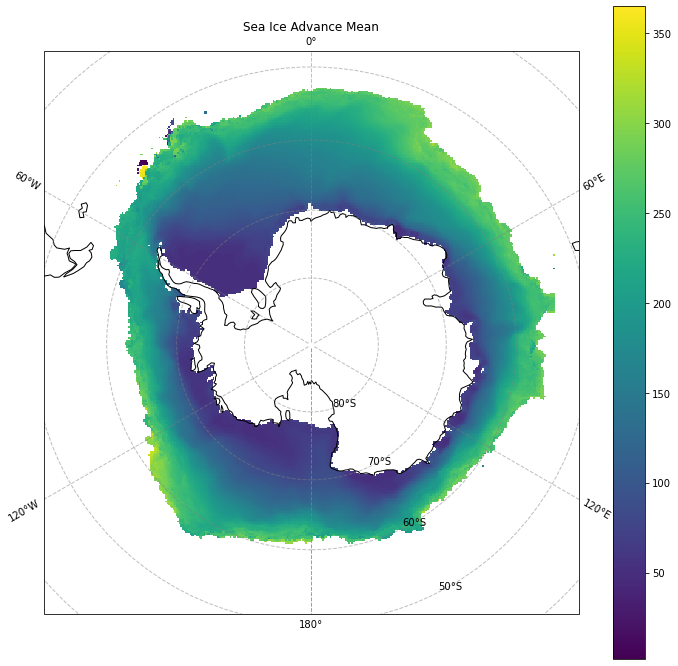

In [42]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    adv_mean_day_da.x,
    adv_mean_day_da.y,
    adv_mean_day_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

gl = ax.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
    #xlocs=[80,120,160], ylocs=[-60,-90]
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Advance Mean')

Text(0.5, 1.0, 'Sea Ice Retreat')

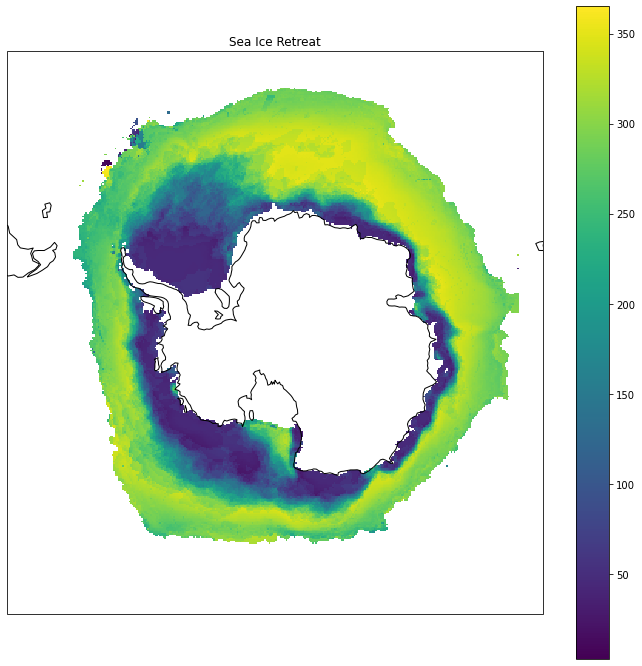

In [43]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    ret_mean_day_da.x,
    ret_mean_day_da.y,
    ret_mean_day_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Retreat')

Text(0.5, 1.0, 'Sea Ice Duration')

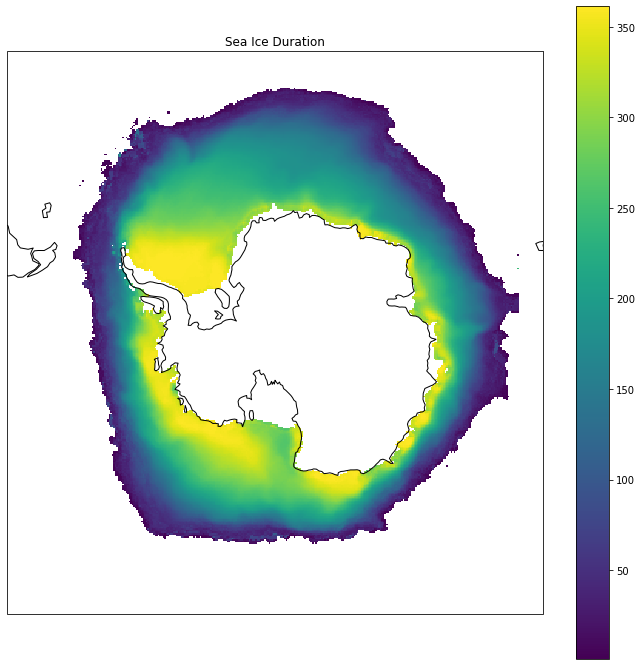

In [44]:
plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    duration_mean_da.x,
    duration_mean_da.y,
    duration_mean_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Duration')

# Anomalies

In [ ]:
to_plot_da=(adv_dayofyear_da-adv_mean_day_da).sel(year=2022)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu_r'
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Advance')

In [ ]:
to_plot_da=(ret_dayofyear_da-ret_mean_day_da).sel(year=2021)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu'
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Retreat')

In [ ]:
to_plot_da=(duration_da-duration_mean_da).sel(year=2021)

plt.figure(figsize=(12,12))
ax=plt.subplot(projection=ccrs.SouthPolarStereo())

plt.pcolormesh(
    to_plot_da.x,
    to_plot_da.y,
    to_plot_da,
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    cmap='RdBu'
)

ax.coastlines()
plt.colorbar()
plt.title('Sea Ice Duration - 2021')

In [ ]:
import hvplot.xarray

In [ ]:
to_plot_da=(duration_da-duration_mean_da)


to_plot_da.hvplot.quadmesh(
    cmap='RdBu',
    rasterize=True,
    frame_height=500,
    frame_width=800
)



- Validation

- Add stipling ??

- Add grid